In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from functools import reduce
import researchpy as rp
import scipy.stats as stats
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from itertools import cycle, islice
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

In [3]:
class fundamental_analysis:

    def __init__(self,exchange):
            
        self.exchange = exchange
        self.year_to_filter = 2013
        self.num_of_groups = 10
        self.fundamental_df = fundamental_analysis.get_final_data(self.exchange,self.year_to_filter,self.num_of_groups)
        self.symbols = list(self.fundamental_df['Symbol'].unique())

    def change_float_column_to_bins(financial_df,column,num_of_groups):

        return financial_df.groupby(['Year'])[column].transform(
            lambda x: pd.qcut(x, num_of_groups, labels=[i+1 for i in range(num_of_groups)]))

    def extract_df_to_list_by_symbol(df):
        symbols = list(df['Symbol'].unique())
        return [df[df['Symbol']==symbol] for symbol in symbols]   

    def get_strings_to_convert_to_float(df):

        string_to_float_columns = list(df.select_dtypes(include='object').columns)
        strings_to_remove = ['Symbol','Industry']
        for string_to_remove in strings_to_remove:
            string_to_float_columns.remove(string_to_remove)

        return string_to_float_columns 

    def convert_data_to_bins(df,num_of_groups):

        string_to_float_columns = fundamental_analysis.get_strings_to_convert_to_float(df)
        columns_to_drop = []
        for column in string_to_float_columns:
            df[column] = [float(value) for value in df[column]]
            try:
                df[column] = fundamental_analysis.change_float_column_to_bins(df,column,num_of_groups)
            except:
                columns_to_drop.append(column)

        df.drop(columns_to_drop,axis=1,inplace=True)

        return df

    def drop_irrelevant_column(df,column):

        indices = [i for i, s in enumerate(list(df.columns)) if column in s]

        return df.drop(df.columns[indices], axis=1)

    def drop_all_irrelevant_columns(df):

        columns_to_drop = ['period','finalLink','reportedCurrency','link','fillingDate','acceptedDate']

        for column in columns_to_drop:
            df = fundamental_analysis.drop_irrelevant_column(df,column)

        return df


    def correct_duplicate_columns(df):
        return df.loc[:,~df.columns.duplicated()]

    def create_filtered_dataframe(stock_df,year_to_filter):

        YEAR = 'Year'
        stock_df = stock_df.T
        stock_df = stock_df.reset_index().rename(columns = {"index":YEAR})
        stock_df[YEAR] = [int(year) for year in stock_df[YEAR]]
        stock_df_filtered = stock_df.sort_values(YEAR).set_index(YEAR).loc[year_to_filter:]
        stock_df_filtered = fundamental_analysis.correct_duplicate_columns(stock_df_filtered)

        return stock_df_filtered

    def create_new_columns_to_dataframe(stock_df):

        YEAR = 'Year'
        CURRENT_ASSET = 'totalCurrentAssets'
        CURRENT_LIABILITIES = 'totalCurrentLiabilities'
        REVENUE = 'revenue'
        TOTAL_ASSETS = 'totalAssets'
        PPE_NET = 'propertyPlantEquipmentNet'
        TOTAL_DEBT = 'totalDebt'
        EBITDA = 'ebitda'
        NET_INCOME = 'netIncome'
        STOCK_HOLDER_EQUITY = 'totalStockholdersEquity'
        CASH_AND_SHORT_INV = 'cashAndShortTermInvestments'
        NON_CURRENT_LIABILITIES = 'totalNonCurrentLiabilities'

        try:
            stock_df['current_ratio'] = stock_df[CURRENT_ASSET] / stock_df[CURRENT_LIABILITIES]
        except:
            stock_df['current_ratio'] = 0 
        try:
            stock_df['total_assets_turnover'] = stock_df[REVENUE] / stock_df[TOTAL_ASSETS] 
        except:
            stock_df['total_assets_turnover'] = 0 
        try:
            stock_df['net_assets_turnover'] = stock_df[REVENUE] / (stock_df[TOTAL_ASSETS] - stock_df[CURRENT_LIABILITIES])
        except:
            stock_df['net_assets_turnover'] = 0 
        try:
            stock_df['pp&e_turnover_ratio'] = stock_df[PPE_NET] / stock_df[REVENUE]
        except:
            stock_df['pp&e_turnover_ratio'] = 0 
        try:
            stock_df['cash_turnover'] = stock_df[REVENUE] / stock_df[CASH_AND_SHORT_INV]
        except:
            stock_df['cash_turnover'] = 0 
        try:
            stock_df['debt_to_equity'] = stock_df[TOTAL_DEBT] / stock_df[STOCK_HOLDER_EQUITY] 
        except:
            stock_df['debt_to_equity'] = 0 
        try:
            stock_df['debt_to_capital'] = stock_df[TOTAL_DEBT] / (stock_df[STOCK_HOLDER_EQUITY] + stock_df[TOTAL_DEBT])
        except:
            stock_df['debt_to_capital'] = 0 
        try:
            stock_df['total_liabilities_to_equity'] = stock_df[NON_CURRENT_LIABILITIES] / stock_df[STOCK_HOLDER_EQUITY]
        except:
            stock_df['total_liabilities_to_equity'] = 0 
        try:
            stock_df['total_assets_to_equity'] = stock_df[TOTAL_ASSETS] / stock_df[STOCK_HOLDER_EQUITY] 
        except:
            stock_df['total_assets_to_equity'] = 0 
        try:
            stock_df['Debt/Equity'] = stock_df[TOTAL_DEBT]/stock_df[STOCK_HOLDER_EQUITY]
        except:
            stock_df['Debt/Equity'] = 0 
        try:
            stock_df['ROE'] = stock_df[NET_INCOME]/stock_df[STOCK_HOLDER_EQUITY]
        except:
            stock_df['ROE'] = 0 
        try:
            stock_df['ROA'] = stock_df[NET_INCOME]/stock_df[TOTAL_ASSETS]
        except:
            stock_df['ROA'] = 0 
        try:
            stock_df['net_current_asset_new'] = stock_df[TOTAL_ASSETS] - stock_df[CURRENT_LIABILITIES]
        except:
            stock_df['net_current_asset_new'] = 0 
        try:
            stock_df['return_on_capital_greenblat'] = stock_df[EBITDA]/stock_df['net_current_asset_new']
        except:
            stock_df['return_on_capital_greenblat'] = 0    
        try:
            stock_df['P/Co'] = stock_df['marketCapitalization']/stock_df['operatingCashFlow']
        except:
            stock_df['P/Co'] = 0 
        try:
            stock_df['P/FcF'] = stock_df['marketCapitalization']/stock_df['freeCashFlow']
        except:
            stock_df['P/FcF'] = 0 
        try:
            stock_df['P/S'] = stock_df['marketCapitalization']/stock_df['revenue']
        except:
            stock_df['P/S'] = 0 
        try:
            stock_df['P/E'] = stock_df['marketCapitalization']/stock_df['netIncome']
        except:
            stock_df['P/E'] = 0 
        try:
            stock_df['Book-to-Market'] = stock_df['totalStockholdersEquity']/stock_df['marketCapitalization']
        except:
            stock_df['Book-to-Market'] = 0 

        return stock_df

    def get_enterprise_data(market,symbol):

        enterprise_df = pd.read_csv("/Users/edenshrian/Desktop/Documents/Economics/MA - Financial Economics/Final Project/EV/" + market + "_EV/" + symbol + ".csv")
        enterprise_df = enterprise_df.rename(columns={"Unnamed: 0":"Index"}).set_index("Index").T.reset_index().rename(columns={"index":"Year"})
        enterprise_df = fundamental_analysis.convert_dataframe_type(enterprise_df)

        return enterprise_df

    def convert_dataframe_type(df):

        df['stockPrice'] = df['stockPrice'].astype('float')
        df['Year'] = df['Year'].astype('int')
        df['numberOfShares'] = df['numberOfShares'].astype('float')
        df['marketCapitalization'] = df['marketCapitalization'].astype('float')
        df['minusCashAndCashEquivalents'] = df['minusCashAndCashEquivalents'].astype('float')
        df['addTotalDebt'] = df['addTotalDebt'].astype('float')
        df['enterpriseValue'] = df['enterpriseValue'].astype('float')

        return df

    def get_industry_data(country):

        df = pd.read_csv("/Users/edenshrian/Desktop/Documents/Economics/MA - Financial Economics/Final Project/Industry/"+country+"_indst.csv")
        df = df.T[1:].reset_index()
        df.columns = ['Symbol','Industry']

        return df


    def get_final_df(country_df,exchange,symbol,year_to_filter):

        stock_df = country_df[symbol]
        enterprise_filtered_df = fundamental_analysis.get_enterprise_data(exchange,symbol)
        stock_df_filtered = fundamental_analysis.create_filtered_dataframe(stock_df,year_to_filter)
        final_df = stock_df_filtered.merge(enterprise_filtered_df,on=['Year'])
        final_df = fundamental_analysis.create_new_columns_to_dataframe(final_df)
        final_df = final_df.reset_index()
        final_df['Symbol'] = symbol

        return final_df 

    def get_final_data(country,year_to_filter,num_of_groups):

        country_df = pd.read_pickle("/Users/edenshrian/Desktop/Documents/Economics/MA - Financial Economics/Final Project/Fundamental Data and Prices/" + country + " Data.pickle")
        symbols = list(country_df.keys())

        panels = []
        for symbol in symbols:
            final_df = fundamental_analysis.get_final_df(country_df,country,symbol,year_to_filter)
            panels.append(final_df)

        final_df = pd.concat(panels)
        industry_df = fundamental_analysis.get_industry_data(country)
        final_df = final_df.merge(industry_df,on=['Symbol'])
        final_df = final_df.drop(['index'],axis=1)
        final_df = fundamental_analysis.drop_all_irrelevant_columns(final_df)
        final_df = final_df.drop(['stockPrice','symbol','numberOfShares','minusCashAndCashEquivalents','addTotalDebt'],axis=1)
        final_df = fundamental_analysis.convert_data_to_bins(final_df,num_of_groups)

        return final_df

In [4]:
class Techincal_analyzer:
    
    def __init__(self,exchange):
        
        self.exchange = exchange
        self.prices_df= 0 
        self.columns = 0
        self.num_of_days_before = 0
        self.panel_list = 0
        self.panel_df = 0
        self.path = 0
        self.country = 0
        self.panel_technical_df = 0
        self.annual_df = 0

    def calculate_technical_indicators(self,dataframe):
        
        self.prices_df = dataframe
        self.prices_df = Techincal_analyzer.SMA(self.prices_df)
        self.prices_df = Techincal_analyzer.SMA_Volume(self.prices_df)
        self.prices_df = Techincal_analyzer.previus_day_high_low(self.prices_df)
        self.prices_df = Techincal_analyzer.stochastic(self.prices_df)
        self.prices_df = Techincal_analyzer.RSI(self.prices_df)
        self.prices_df = Techincal_analyzer.MACD(self.prices_df)
        self.prices_df = Techincal_analyzer.bollinger_band(self.prices_df)
        self.prices_df = Techincal_analyzer.OBV_calculation(self.prices_df)
        self.prices_df = self.prices_df.set_index('Date')
        self.columns = list(self.prices_df.columns)
        self.prices_df = self.prices_df.reset_index() 
        self.prices_df['Year'] = [pd.to_datetime(self.prices_df['Date']).iloc[i].year for i in range(len(list(self.prices_df.index)))]

        return 
    
    def create_panel_data(self,num_of_days_before):
        
        self.num_of_days_before = num_of_days_before
        self.panel_technical_df = Techincal_analyzer.get_panel_stock_df(self.prices_df,self.num_of_days_before)
        self.annual_df = Techincal_analyzer.create_annual_technical_df(self.prices_df)
        
        return 
    
    def get_substring(path_directory,country):
    
        start = path_directory.find("{}/".format(country)) + len("{}/".format(country))
        end = path_directory.find(".csv")
        substring = path_directory[start:end]

        return substring
    
    def get_country(path):
    
        if "NYE" in path:
            country = "NYE"
            return country
        elif "India" in path:
            country = "India"
            return "India"
        else:
            print("Choose between NYE,India")
    
    def SMA(prices_df):

        prices_df['SMA_5'] = prices_df['Close'].transform(lambda x: x.rolling(window = 5).mean())
        prices_df['SMA_15'] = prices_df['Close'].transform(lambda x: x.rolling(window = 15).mean())
        prices_df['SMA_ratio'] = prices_df['SMA_5']/prices_df['SMA_15']

        return prices_df

    def SMA_Volume(prices_df):

        prices_df['SMA5_Volume'] = prices_df['Volume'].transform(lambda x: x.rolling(window = 5).mean())
        prices_df['SMA15_Volume'] = prices_df['Volume'].transform(lambda x: x.rolling(window = 15).mean())
        prices_df['SMA_Volume_Ratio'] = prices_df['SMA5_Volume']/prices_df['SMA15_Volume']

        return prices_df

    def previus_day_high_low(prices_df):

        prices_df['prev_high'] = prices_df['High'].shift(1)
        prices_df['prev_low'] = prices_df['Low'].shift(1)

        return prices_df

    def stochastic(prices_df):

        prices_df['Lowest_10D'] = prices_df['Low'].transform(lambda x: x.rolling(window = 10).min())
        prices_df['High_10D'] = prices_df['High'].transform(lambda x: x.rolling(window = 10).max())
        prices_df['Lowest_30D'] = prices_df['Low'].transform(lambda x: x.rolling(window = 30).min())
        prices_df['High_30D'] = prices_df['High'].transform(lambda x: x.rolling(window = 30).max())

        prices_df['Stochastic_10'] = ((prices_df['Close'] - prices_df['Lowest_10D'])/(prices_df['High_10D'] - prices_df['Lowest_10D']))*100
        prices_df['Stochastic_30'] = ((prices_df['Close'] - prices_df['Lowest_30D'])/(prices_df['High_30D'] - prices_df['Lowest_30D']))*100

        prices_df['Stochastic_%D_10'] = prices_df['Stochastic_10'].rolling(window = 10).mean()
        prices_df['Stochastic_%D_30'] = prices_df['Stochastic_30'].rolling(window = 30).mean()

        prices_df['Stochastic_Ratio'] = prices_df['Stochastic_%D_10']/prices_df['Stochastic_%D_30']

        return prices_df

    def RSI(prices_df):

        prices_df['Diff'] = prices_df['Close'].transform(lambda x: x.diff())
        prices_df['Up'] = prices_df['Diff']
        prices_df.loc[(prices_df['Up']<0), 'Up'] = 0

        prices_df['Down'] = prices_df['Diff']
        prices_df.loc[(prices_df['Down']>0), 'Down'] = 0 
        prices_df['Down'] = abs(prices_df['Down'])

        prices_df['avg_5up'] = prices_df['Up'].transform(lambda x: x.rolling(window=5).mean())
        prices_df['avg_5down'] = prices_df['Down'].transform(lambda x: x.rolling(window=5).mean())

        prices_df['avg_15up'] = prices_df['Up'].transform(lambda x: x.rolling(window=15).mean())
        prices_df['avg_15down'] = prices_df['Down'].transform(lambda x: x.rolling(window=15).mean())

        prices_df['RS_5'] = prices_df['avg_5up'] / prices_df['avg_5down']
        prices_df['RS_15'] = prices_df['avg_15up'] / prices_df['avg_15down']

        prices_df['RSI_5'] = 100 - (100/(1+prices_df['RS_5']))
        prices_df['RSI_15'] = 100 - (100/(1+prices_df['RS_15']))

        prices_df['RSI_ratio'] = prices_df['RSI_5']/prices_df['RSI_15']

        return prices_df

    def MACD(prices_df):

        prices_df['12Ewm'] = prices_df['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
        prices_df['26Ewm'] = prices_df['Close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())
        prices_df['MACD'] = prices_df['26Ewm'] - prices_df['12Ewm']

        return prices_df

    def upper_lower_bounds(prices_df):

        prices_df['15MA'] = prices_df['Close'].transform(lambda x: x.rolling(window=15).mean())
        prices_df['SD'] = prices_df['Close'].transform(lambda x: x.rolling(window=15).std())
        prices_df['upperband'] = prices_df['15MA'] + 2*prices_df['SD']
        prices_df['lowerband'] = prices_df['15MA'] - 2*prices_df['SD']

        return prices_df

    def bollinger_band(prices_df):

        prices_df['MA20'] = prices_df['Close'].transform(lambda x: x.rolling(window=20).mean()) 
        prices_df['20dSTD'] = prices_df['Close'].transform(lambda x: x.rolling(window=20).std()) 

        prices_df['Upper'] = prices_df['MA20'] + (prices_df['20dSTD'] * 2)
        prices_df['Lower'] = prices_df['MA20'] - (prices_df['20dSTD'] * 2)
        prices_df = prices_df.drop(['MA20','20dSTD'],axis=1)

        return prices_df

    def OBV_calculation(prices_df):

        OBV = []
        OBV.append(0)

        for i in range(1,len(prices_df.Close)):
            if prices_df.Close[i] > prices_df.Close[i-1]:
                OBV.append(OBV[-1]+prices_df.Volume[i])
            elif prices_df.Close[i] < prices_df.Close[i-1]:
                OBV.append(OBV[-1]+prices_df.Volume[i]) 
            else:
                OBV.append(OBV[-1])

        prices_df['OBV'] = OBV
        prices_df['OBV_EMA'] = prices_df['OBV'].ewm(span=20).mean()

        return prices_df

    def return_in_last_n_days(prices_df,n):
        
        prices_df['Precentage Change'] = np.log(prices_df['Close'])-np.log(prices_df['Close'].shift(n))
        return prices_df
    
    def create_annual_technical_df(technical_df):
        return pd.DataFrame(technical_df.groupby(['Symbol','Year'])['Precentage Change'].mean()).reset_index()


    def extract_df_to_list_by_symbol(df):
        symbols = list(df['Symbol'].unique())
        return [df[df['Symbol']==symbol] for symbol in symbols]

    def create_shift_column(df,column_name,num_of_steps):

        column_df = pd.DataFrame(df[column_name].shift(num_of_steps))
        column_df.columns = [column_name + f' t-{num_of_steps}']  

        return pd.concat([df, column_df], axis=1)

    def update_columns(df,columns_to_shift,num_of_steps):

        for column in columns_to_shift:
            df = Techincal_analyzer.create_shift_column(df,column,num_of_steps)

        return df

    def update_multiple_shifts(df,columns_to_shift,num_of_steps):

        for num in list(np.arange(1,num_of_steps+1)):
            df = Techincal_analyzer.update_columns(df,columns_to_shift,num)

        return df

    def choose_column_by_type(df,object_type):
        return list(df.select_dtypes(object_type).columns)

    def extract_index_from_begin_list(list1):

        return list1[1:]

    def extract_index_from_end_list(list1):

        return list1[:-1]

    def update_dataframe_columns_to_crossectional(df,num_of_shifts):

        columns_to_shift = Techincal_analyzer.choose_column_by_type(df,"float")
        columns_to_shift = Techincal_analyzer.extract_index_from_begin_list(columns_to_shift)
        df = Techincal_analyzer.update_multiple_shifts(df,columns_to_shift,num_of_shifts)    
        df = df.dropna()

        return df

    def get_panel_stock_df(df,num_of_shifts):

        columns_to_shift = Techincal_analyzer.choose_column_by_type(df,"float")
        columns_to_shift = Techincal_analyzer.extract_index_from_end_list(columns_to_shift)
        df = Techincal_analyzer.update_multiple_shifts(df,columns_to_shift,num_of_shifts)  

        return df[num_of_shifts:]

## Helper functions

In [130]:
def get_list_of_directories(exchange,symbols):
    
    return [f'/Users/edenshrian/Desktop/Documents/Economics/MA - Financial Economics/Final Project/{exchange}/' + symbol + '.csv' for symbol in symbols] 

def get_mean_annual_return_per_bin(exchange_df,variable_to_check):
    
    annualized_per_bin_df = exchange_df.groupby([variable_to_check])['Next Annual Return'].mean()
    annualized_per_bin_df = pd.DataFrame(annualized_per_bin_df).reset_index()
    column_to_remain = annualized_per_bin_df.columns[0]
    annualized_per_bin_df.columns=['Bins',column_to_remain]
    needed_for_plot = annualized_per_bin_df.loc[(annualized_per_bin_df['Bins']==1) | (annualized_per_bin_df['Bins']==10)]
    
    return needed_for_plot

def check_statistically_diffrence(nye_df,anomaly):
    
    summary, results = rp.ttest(group1= nye_df['Next Annual Return'][nye_df[anomaly] == 1], group1_name= "Low",
                                group2= nye_df['Next Annual Return'][nye_df[anomaly] == 10], group2_name= "High")
    
    return summary,results

def choose_stocks_to_portfolio(start_of_year_df,year,symbols_nye):
    
    yearly_data = start_of_year_df[start_of_year_df['Year']==year].head(len(symbols_nye))
    yearly_data = yearly_data.drop(['Month','Day','Year'],axis=1)
    yearly_data = yearly_data.sort_values('Predictions',ascending=False)
    num_of_stocks = 20
    value = 100000
    long_only = yearly_data.head(num_of_stocks)
    long_only = long_only.copy()
    long_only['Weights'] = 1/len(long_only)*value
    long_only['Return for Portfolio'] = long_only['True Return']*long_only['Weights']
    
    short_only = yearly_data.tail(num_of_stocks)
    short_only = short_only.copy()
    short_only['True Return'] = -1*short_only['True Return']
    short_only['Weights'] = 1/len(short_only)*value
    short_only['Return for Portfolio'] = short_only['True Return']*short_only['Weights']
    
    mixed_long = yearly_data.head(int(num_of_stocks/2))
    mixed_short = yearly_data.tail(int(num_of_stocks/2))
    mixed_short['True Return'] = -1*mixed_short['True Return']
    mixed_df = pd.concat([mixed_long,mixed_short])
    mixed_df = mixed_df.copy()
    mixed_df['Weights'] = 1/len(mixed_df)*value
    mixed_df['Return for Portfolio'] = mixed_df['True Return']*mixed_df['Weights']
    
    return long_only,short_only,mixed_df

def get_positions_value(longs,dfs,year):
    
    dfs = dfs.set_index('Date')
    buy_2014 = longs[longs['Year']==year]['Symbol'].values
    portfolio_2014 = dfs[(dfs['Symbol'].isin(buy_2014))].loc[str(year)]
    portfolio_2014 = portfolio_2014[['Symbol','Close']].reset_index()
    portfolio_2014 = portfolio_2014.pivot_table(index=['Date'], columns='Symbol', values=['Close'])
    portfolio_2014.columns = [col[1] for col in portfolio_2014.columns.values]
    df_daily_returns = portfolio_2014.pct_change()
    df_daily_returns = df_daily_returns[1:]
    df_daily_returns['Average Return'] = (df_daily_returns.mean(axis=1))
    
    return df_daily_returns[['Average Return']]

def anomaly_buy_sell_other(in_sample_annual_df,anomaly,year):
    
    num_of_stocks = 20
    df_year1 = in_sample_annual_df[(in_sample_annual_df[anomaly]==1)&(in_sample_annual_df['Year']==year)].head(int(num_of_stocks/2))
    symbols_to_buy = list(df_year1['Symbol'].values)
    df_year10 = in_sample_annual_df[(in_sample_annual_df[anomaly]==10)&(in_sample_annual_df['Year']==year)].tail(int(num_of_stocks/2))
    symbols_to_sell = list(df_year10['Symbol'].values)
    df_of_next_year = dfs.set_index('Date').loc[str(year+1),["Close",'Symbol']].dropna()
    df_to_buy = df_of_next_year[df_of_next_year['Symbol'].isin(symbols_to_buy)].reset_index().pivot_table(index=['Date'], columns='Symbol', values=['Close'])
    df_to_buy_return = df_to_buy.pct_change()[1:]
    df_to_buy_return['total'] = df_to_buy_return.mean(axis=1)
    df_to_sell = df_of_next_year[df_of_next_year['Symbol'].isin(symbols_to_sell)].reset_index().pivot_table(index=['Date'], columns='Symbol', values=['Close'])
    df_to_sell_return = df_to_sell.pct_change()[1:]
    df_to_sell_return['total'] = df_to_sell_return.mean(axis=1)
    df_total_anomaly = pd.concat([df_to_buy_return['total'],df_to_sell_return['total']],axis=1)
    df_total_anomaly.columns = ['Buy','Sell']
    df_total_anomaly['total'] = df_total_anomaly.mean(axis=1)
    
    return df_total_anomaly

def anomaly_buy_sell_BTM(in_sample_annual_df,anomaly,year):
    
    num_of_stocks = 20
    df_year1 = in_sample_annual_df[(in_sample_annual_df[anomaly]==1)&(in_sample_annual_df['Year']==year)].head(int(num_of_stocks/2))
    symbols_to_sell = list(df_year1['Symbol'].values)
    df_year10 = in_sample_annual_df[(in_sample_annual_df[anomaly]==10)&(in_sample_annual_df['Year']==year)].tail(int(num_of_stocks/2))
    symbols_to_buy = list(df_year10['Symbol'].values)
    df_of_next_year = dfs.set_index('Date').loc[str(year+1),["Close",'Symbol']].dropna()
    df_to_buy = df_of_next_year[df_of_next_year['Symbol'].isin(symbols_to_buy)].reset_index().pivot_table(index=['Date'], columns='Symbol', values=['Close'])
    df_to_buy_return = df_to_buy.pct_change()[1:]
    df_to_buy_return['total'] = df_to_buy_return.mean(axis=1)
    df_to_sell = df_of_next_year[df_of_next_year['Symbol'].isin(symbols_to_sell)].reset_index().pivot_table(index=['Date'], columns='Symbol', values=['Close'])
    df_to_sell_return = df_to_sell.pct_change()[1:]
    df_to_sell_return['total'] = df_to_sell_return.mean(axis=1)
    df_total_anomaly = pd.concat([df_to_buy_return['total'],df_to_sell_return['total']],axis=1)
    df_total_anomaly.columns = ['Buy','Sell']
    df_total_anomaly['total'] = df_total_anomaly.mean(axis=1)
    
    return df_total_anomaly

def create_anomaly_portfolio_value(dfs,in_sample_annual_df,anomaly):
    
    in_sample_annual_df = in_sample_annual_df.sort_values(['Year',anomaly,'Annual Return'],ascending=[True,True,True]).dropna(axis=0)
    num_of_stocks = 20
    years = list(in_sample_annual_df['Year'].unique())
    
    if anomaly != "Book-to-Market":
    
        df_total_anomalies = []
        for year in years:
            df_total_anomaly = anomaly_buy_sell_other(in_sample_annual_df,anomaly,year)
            df_total_anomalies.append(df_total_anomaly)

        df_both = pd.concat(df_total_anomalies)
        df_both1 = df_both.copy()
        df_both[anomaly] = (1+df_both['total']).cumprod()*100000
        df_both = df_both.loc[:'2019-12-31']
        
    else:
        
        df_total_anomalies = []
        for year in years:
            df_total_anomaly = anomaly_buy_sell_BTM(in_sample_annual_df,anomaly,year)
            df_total_anomalies.append(df_total_anomaly)

        df_both = pd.concat(df_total_anomalies)
        df_both1 = df_both.copy()
        df_both[anomaly] = (1+df_both['total']).cumprod()*100000
        df_both = df_both.loc[:'2019-12-31']
        
    return df_both,df_both1

def check_statistically_difference(nye_df,anomaly):
    
    summary, results = rp.ttest(group1= nye_df['Next Annual Return'][nye_df[anomaly] == 1], group1_name= "Low",
                                group2= nye_df['Next Annual Return'][nye_df[anomaly] == 10], group2_name= "High")
    
    return summary,results

def get_full_df(list_of_dfs):
    
    [tech.calculate_technical_indicators(df) for df in list_of_dfs]
    df_all_symbols = pd.concat(list_of_dfs)
    df_all_symbols['Date'] = pd.to_datetime(df_all_symbols['Date'])
    df_all_symbols = df_all_symbols.set_index('Date')
    dfs = df_all_symbols.loc["2012-01-03":]
    dfs = dfs.sort_index()
    dfs.reset_index(inplace=True)
    dfs['Month'] = dfs['Date'].dt.month
    dfs['Year'] = dfs['Date'].dt.year
    
    return dfs

def get_end_of_month(dfs):
    
    end_of_month_df = dfs.sort_values('Date').groupby(['Symbol','Year','Month']).tail(1)
    end_of_month_df = end_of_month_df[end_of_month_df['Month']==12].sort_values(['Symbol','Date']).drop(['Month'],axis=1)
    annual_end_df = end_of_month_df[['Date','Symbol','Close']]
    
    return annual_end_df

def add_annual_return(stock_df,symbol):
    
    stock_df = stock_df.copy()
    stock_df['Annual Return'] = stock_df['Close']/stock_df['Close'].shift(1) - 1
    stock_df['Log Annual Return'] = np.log(stock_df['Close'])-np.log(stock_df['Close'].shift(1))
    stock_df['Next Annual Return'] = stock_df['Annual Return'].shift(-1)
    stock_df['Next Annual Log Return'] =stock_df['Log Annual Return'].shift(-1)
    
    return stock_df

def divide_to_in_sample_out_sample(annual_df):
    
    out_of_sample_annual_df = annual_df[annual_df['Next Annual Return'].isnull()]
    in_sample_annual_df = annual_df[~annual_df['Next Annual Return'].isnull()]
    in_sample_annual_df = in_sample_annual_df.dropna(axis=0)
    
    return in_sample_annual_df,out_of_sample_annual_df

def add_momentum(in_sample_annual_df):
    
    in_sample_annual_df['Momentum'] = in_sample_annual_df.groupby(['Year'])['Annual Return'].transform(
        lambda x: pd.qcut(x, 10, labels=[i+1 for i in range(10)]))
    
    return in_sample_annual_df

def add_size(country_df,in_sample_annual_df):
    
    country_df = country_df.merge(in_sample_annual_df,on=['Year','Symbol'])
    country_df['Size']= country_df.groupby(['Year'])['marketCapitalization'].transform(
        lambda x: pd.qcut(x, 10, labels=[i+1 for i in range(10)]))
    
    return country_df

def train_test_split_for_time_series(input_data,output_data,test_split):

    split_size = int(len(input_data)*(1-test_split))
    X_train = input_data[:split_size]
    X_test = input_data[split_size:]
    y_train = output_data[:split_size]
    y_test = output_data[split_size:]

    return X_train,X_test,y_train,y_test

def get_average_return_startegy(strategy,strategy_df,dfs,start_year,end_year):
    
    average_return = pd.concat([get_positions_value(strategy_df,dfs,year) for year in np.arange(start_year,end_year+1)])
    average_return = (1+average_return).cumprod()*100000
    average_return.columns = [strategy]
    
    return average_return

def convert_monthly_return_to_annual(average_return):
    
    average_return = average_return.reset_index()
    average_return['Year'] = average_return['Date'].dt.year
    average_annual_return = ((1+average_return.groupby(['Year'])['Average Return'].mean())**(252)-1)
    
    return average_annual_return

## NYE

In [159]:
nye = fundamental_analysis("NYE")
tech = Techincal_analyzer("NYE")
nye_df = nye.fundamental_df
symbols_nye = nye.symbols
symbols_nye.remove("ADT")
directories_nye = get_list_of_directories("NYE",symbols_nye)
list_dfs = [pd.read_csv(directory) for directory in directories_nye]

list_of_dfs = []
for symbol, df in zip(symbols_nye,list_dfs):
    df['Symbol'] = symbol
    list_of_dfs.append(df)

In [160]:
dfs = get_full_df(list_of_dfs)
annual_end_df = get_end_of_month(dfs)

In [161]:
annual_df_lists = []
for symbol in symbols_nye:
    annual_end_df = annual_end_df.copy()
    stock_df = annual_end_df[annual_end_df['Symbol']==symbol]
    stock_df = add_annual_return(annual_end_df,symbol)
    annual_df_lists.append(stock_df)
    
annual_df = pd.concat(annual_df_lists).drop(['Close'],axis=1)
annual_df['Year'] = annual_df['Date'].dt.year
annual_df = annual_df.set_index("Date").loc["2012-12-31":].reset_index()

In [162]:
in_sample_annual_df,out_of_sample_annual_df = divide_to_in_sample_out_sample(annual_df)
in_sample_annual_df = add_momentum(in_sample_annual_df)
nye_df = add_size(nye_df,in_sample_annual_df)
nye_df = nye_df.sort_values('Date')
nye_df = nye_df.drop_duplicates()

In [163]:
anomalies = ["Size","Momentum","return_on_capital_greenblat","Book-to-Market"]

for anomaly in anomalies:
    summary,results = check_statistically_difference(nye_df,anomaly)
    print(anomaly)
    print(summary)
    print(results)
    print('---------')

Size
   Variable      N      Mean        SD        SE  95% Conf.  Interval
0       Low  155.0  0.509446  2.798636  0.224792   0.065372  0.953519
1      High  147.0 -0.024575  0.341256  0.028146  -0.080202  0.031051
2  combined  302.0  0.249508  2.033525  0.117016   0.019235  0.479782
           Independent t-test   results
0  Difference (Low - High) =     0.5340
1       Degrees of freedom =   300.0000
2                        t =     2.2972
3    Two side test p value =     0.0223
4   Difference < 0 p value =     0.9889
5   Difference > 0 p value =     0.0111
6                Cohen's d =     0.2645
7                Hedge's g =     0.2638
8            Glass's delta =     0.1908
9                        r =     0.1315
---------
Momentum
   Variable      N      Mean        SD        SE  95% Conf.  Interval
0       Low  154.0  0.511028  2.847962  0.229495   0.057639  0.964416
1      High  147.0  0.159714  0.594959  0.049071   0.062732  0.256696
2  combined  301.0  0.339456  2.083209  0.1200

In [164]:
needed_columns = nye_df.select_dtypes('category').columns
list_of_anomalies = [get_mean_annual_return_per_bin(nye_df,column) for column in needed_columns]
list_of_anomalies = [df.set_index('Bins') for df in list_of_anomalies]
df_anomalies = pd.concat(list_of_anomalies,axis=1)

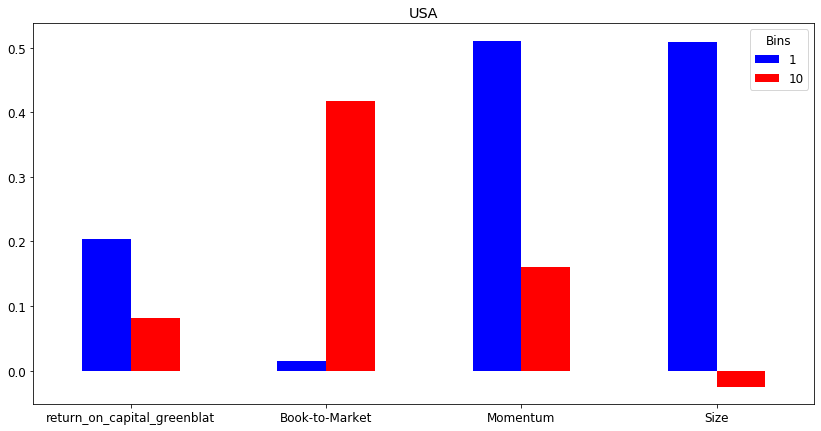

In [165]:
df_to_plot = df_anomalies[['return_on_capital_greenblat','Book-to-Market','Momentum','Size']]
my_colors = list(islice(cycle(['b', 'r']), None, len(df_to_plot)))
plt.rcParams.update({'font.size': 12});
df_to_plot.T.plot(kind='bar',figsize=(14,7),color=my_colors,rot=0);
plt.title("USA");

In [166]:
df_to_analysis = dfs.merge(nye_df.drop(['Date'],axis=1),on=['Symbol','Year'])
df_to_analysis = df_to_analysis.sort_values('Date')

In [167]:
df_to_analysis = df_to_analysis.drop(['Open','High','Low','Adj Close','Close','Volume',
                                      'SMA_5','SMA_15','SMA5_Volume','Month',
                                      'SMA15_Volume','prev_high','Year','Stochastic_Ratio',
                                      'prev_low','Lowest_10D','High_10D',
                                      'Lowest_30D','High_30D','Stochastic_10','Stochastic_30',
                                      'Stochastic_%D_10','Stochastic_%D_30','Diff','Up','RSI_5','RSI_15',
                                      'Down','avg_5up','avg_5down','avg_15up','avg_15down','RS_5','RS_15','ebitda',
                                      '12Ewm','26Ewm','Upper','Lower','Annual Return','Industry','epsdilutedGrowth',
                                      'weightedAverageSharesDilutedGrowth','sellingGeneralAndAdministrativeExpenses',
                                      'cashAndCashEquivalents','retainedEarnings','longTermDebt',
                                      'weightedAverageShsOut','weightedAverageShsOutDil','changeInWorkingCapital',
                                      'otherNonCashItems','netCashProvidedByOperatingActivities', 'otherInvestingActivites',
                                      'netCashUsedForInvestingActivites', 'debtRepayment','otherFinancingActivites',
                                      'netCashUsedProvidedByFinancingActivities','netChangeInCash', 'cashAtEndOfPeriod',
                                      'cashAtBeginningOfPeriod','operatingCashFlow', 'capitalExpenditure', 'freeCashFlow','enterpriseValue'],axis=1).dropna(axis=0)

In [168]:
X = df_to_analysis.drop(labels=['Date','Log Annual Return','Next Annual Return','Next Annual Log Return','Symbol'], axis=1)
y = df_to_analysis['Next Annual Log Return']
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


In [169]:
X_train,X_test,y_train,y_test = train_test_split_for_time_series(X,y,0.2)

In [170]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [171]:
model_lasso = Lasso(alpha=0.001,max_iter=1000)
model_lasso.fit(X_train, y_train) 

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

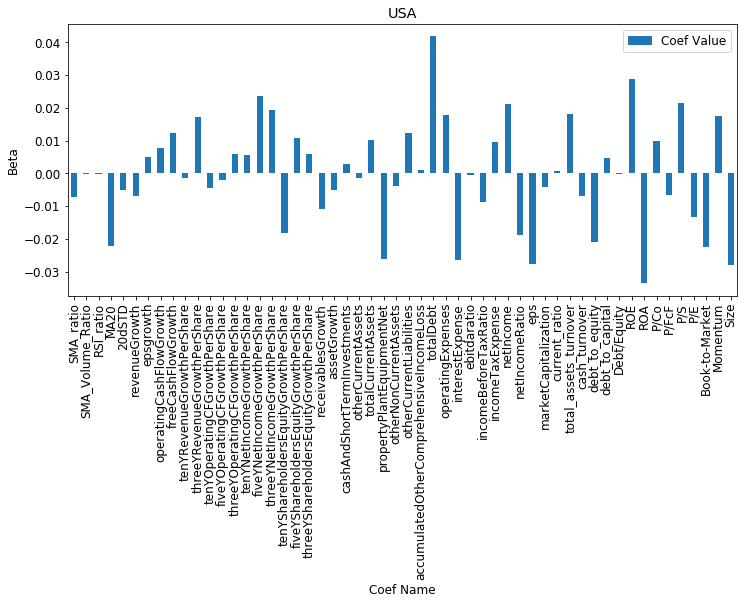

In [172]:
coeffients = model_lasso.coef_
features = list(X.columns)
coef_df = pd.DataFrame()
coef_df['Coef Name'] = np.array(features)[coeffients != 0]
coef_df['Coef Value'] = coeffients[coeffients != 0]
coef_df['Coef Name'] = [coef_df['Coef Name'].iloc[i].replace(" Precentage","") for i in range(len(coef_df['Coef Name']))]
coef_df[(coef_df['Coef Value']>0)|(coef_df['Coef Value']<0)].set_index('Coef Name').plot(kind='bar',figsize=(12,5));
plt.title('USA');
plt.ylabel("Beta");

In [173]:
pred_train_lasso= model_lasso.predict(X_train)
pred_test_lasso= model_lasso.predict(X_test)
prediction_list = list(pred_train_lasso)+list(pred_test_lasso)
dates = list(df_to_analysis['Date'].values)
symbols_in_order = list(df_to_analysis['Symbol'].values)
return_to_predict = list(df_to_analysis['Next Annual Return'].values)

In [174]:
prediction_df = pd.DataFrame({"Date":dates,
                              "Symbol":symbols_in_order,
                              "Predictions":prediction_list,
                              "True Return":return_to_predict,
                              "Month":prediction_df['Date'].dt.month,
                              "Day":prediction_df['Date'].dt.day})

start_of_year_df = prediction_df[(prediction_df['Month']==1)]
start_of_year_df = start_of_year_df.copy()
start_of_year_df['Year'] = start_of_year_df['Date'].dt.year

In [175]:
longs = []
shorts = []
mixed = []
for year in list(start_of_year_df['Year'].unique()):
    
    long_only,short_only,mixed_df = choose_stocks_to_portfolio(start_of_year_df,year,symbols_nye)
    longs.append(long_only)
    shorts.append(short_only)
    mixed.append(mixed_df)
    
mixed = pd.concat(mixed)
mixed = mixed.copy()
longs = pd.concat(longs)
longs = longs.copy()
shorts = pd.concat(shorts)
shorts = shorts.copy()

mixed.loc[:,'Year'] = mixed.loc[:,'Date'].dt.year
longs.loc[:,'Year'] = longs.loc[:,'Date'].dt.year
shorts.loc[:,'Year'] = shorts.loc[:,'Date'].dt.year

mixed.set_index('Date',inplace=True)
longs.set_index('Date',inplace=True)
shorts.set_index('Date',inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


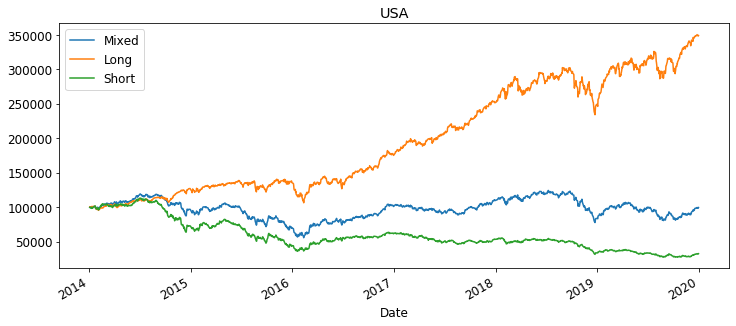

In [176]:
average_return_long1 = get_average_return_startegy("Long",longs,dfs,2014,2019)
average_return_short1 = get_average_return_startegy("Short",shorts,dfs,2014,2019)
average_return_mixed1 = get_average_return_startegy("Mixed",mixed,dfs,2014,2019)

df_portfolio_analyzer = pd.concat([average_return_mixed1,average_return_long1,average_return_short1],axis=1)
df_portfolio_analyzer.plot(kind='line',figsize=(12,5));
plt.title('USA');

In [177]:
sharp_ratio_long = np.round(average_return_long.mean().values[0]/average_return_long.std().values[0]*np.sqrt(252),3)
sharp_ratio_short = np.round(average_return_short.mean().values[0]/average_return_short.std().values[0]*np.sqrt(252),3)
sharp_ratio_mixed = np.round(average_return_mixed.mean().values[0]/average_return_mixed.std().values[0]*np.sqrt(252),3)
sharp_ratios = [sharp_ratio_long,sharp_ratio_short,sharp_ratio_mixed]
type_of_portfolio = ['Long','Short','Mixed']

dataframe_sharp = pd.DataFrame([sharp_ratios,type_of_portfolio]).T
dataframe_sharp.columns = ['Sharp Ratio','Type of investing']

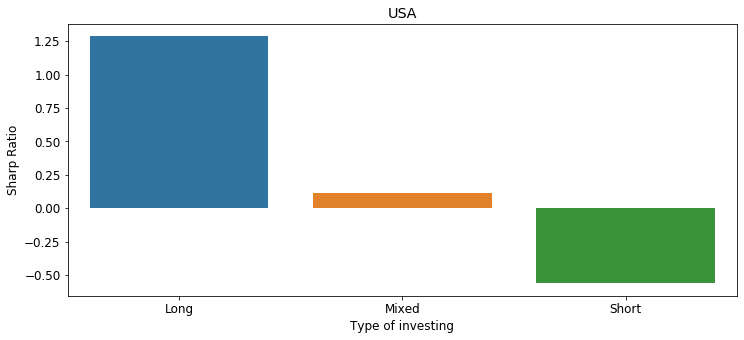

In [178]:
plt.figure(figsize=(12,5))
sns.barplot(x="Type of investing", y="Sharp Ratio", data=dataframe_sharp,order=['Long','Mixed','Short']);
plt.title("USA");

In [179]:
dfs_close = dfs[['Date','Symbol','Close']]
dfs_close = dfs_close.pivot_table(index=['Date'], columns='Symbol', values=['Close'])
dfs_close.columns = [col[1] for col in dfs_close.columns.values]
dfs_close = dfs_close.loc["2014-01-01":].pct_change()
dfs_close = dfs_close[1:]
equal_weighted_portfolio = (1+dfs_close.mean(axis=1)).cumprod()*100000
equal_weighted_portfolio_df = pd.DataFrame(equal_weighted_portfolio)
equal_weighted_portfolio_df.columns=['Equal Weights Portfolio']
df_merged = pd.concat([equal_weighted_portfolio_df,average_return_long1],axis=1).loc[:"2019-12-31"]

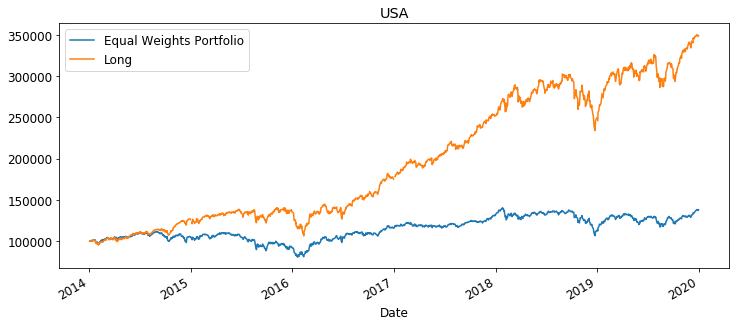

In [180]:
df_merged.plot(kind='line',figsize=(12,5));
plt.title('USA');

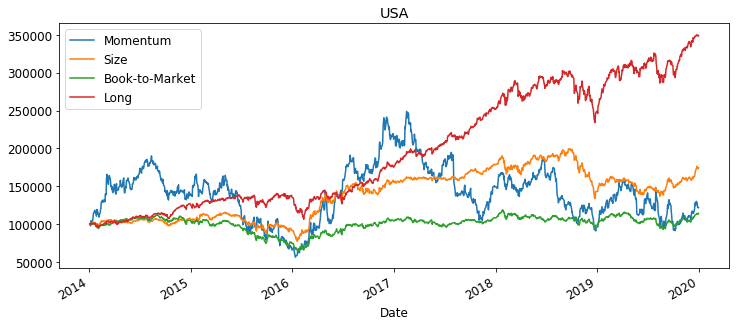

In [181]:
momentum_df,momentum_return_df = create_anomaly_portfolio_value(dfs,in_sample_annual_df,'Momentum')
momentum_df = momentum_df.loc["2014-01-01":]
momentum_df = momentum_df.copy()
momentum_df.loc[:,'Momentum'] = (1+momentum_df['total']).cumprod()*100000
size_df,size_return_df = create_anomaly_portfolio_value(dfs,nye_df,"Size")
btm_df,btm_return_df = create_anomaly_portfolio_value(dfs,nye_df,"Book-to-Market")
pd.concat([momentum_df['Momentum'],size_df['Size'],btm_df['Book-to-Market'],average_return_long1['Long']],axis=1).plot(kind='line',figsize=(12,5));
plt.title('USA');

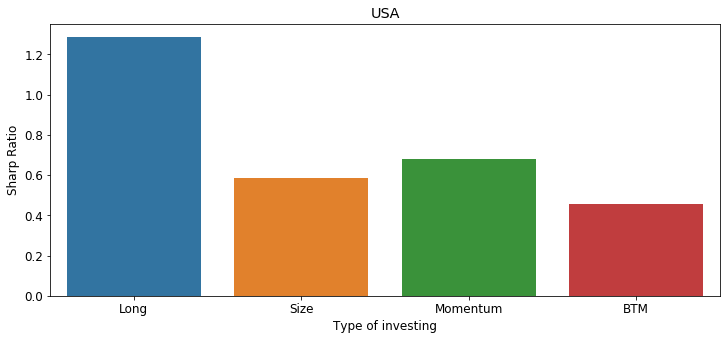

In [182]:
sharp_ratio_momentum = np.round(momentum_return_df.mean().values[0]/momentum_return_df.std().values[0]*np.sqrt(252),3)
sharp_ratio_size = np.round(size_return_df.mean().values[0]/size_return_df.std().values[0]*np.sqrt(252),3)
sharp_ratio_btm = np.round(btm_return_df.mean().values[0]/btm_return_df.std().values[0]*np.sqrt(252),3)
sharp_ratios = [sharp_ratio_momentum,sharp_ratio_size,sharp_ratio_btm,sharp_ratio_long]
type_of_portfolio = ['Momentum','Size','BTM','Long']
dataframe_sharp = pd.DataFrame([sharp_ratios,type_of_portfolio]).T
dataframe_sharp.columns = ['Sharp Ratio','Type of investing']

plt.figure(figsize=(12,5))
sns.barplot(x="Type of investing", y="Sharp Ratio", data=dataframe_sharp,order=['Long','Size','Momentum','BTM']);
plt.title('USA');

In [183]:
size_return_df = size_return_df.rename(columns = {'total':"Average Return"})
btm_return_df = btm_return_df.rename(columns = {'total':"Average Return"})
momentum_return_df = momentum_return_df.loc["2014-01-01":]
momentum_return_df = momentum_return_df.copy()
momentum_return_df = momentum_return_df.rename(columns = {'total':"Average Return"})

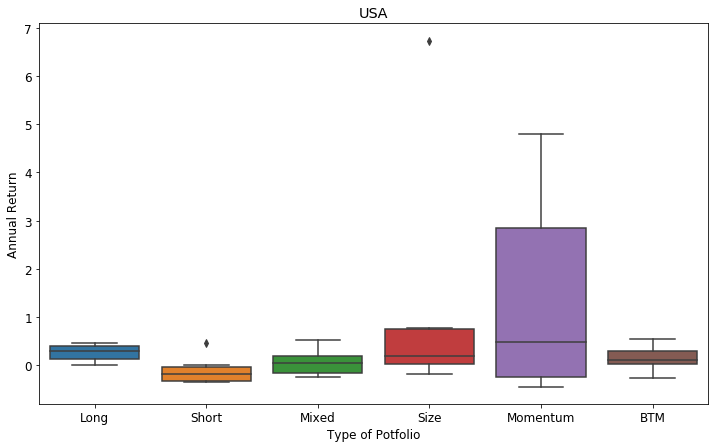

In [184]:
average_annual_return_long = convert_monthly_return_to_annual(average_return_long)
average_annual_return_short = convert_monthly_return_to_annual(average_return_short)
average_annual_return_mixed = convert_monthly_return_to_annual(average_return_mixed)
average_annual_return_size = convert_monthly_return_to_annual(size_return_df)
average_annual_return_btm = convert_monthly_return_to_annual(btm_return_df)
average_annual_return_momentum = convert_monthly_return_to_annual(momentum_return_df)

annual_return_df = pd.concat([average_annual_return_long,average_annual_return_short,average_annual_return_mixed,
                              average_annual_return_size,average_annual_return_momentum,average_annual_return_btm],axis=1)
annual_return_df.columns = ['Long','Short','Mixed','Size','Momentum','BTM']
annual_return_df = annual_return_df.reset_index()
annual_return_df_long_format = pd.melt(annual_return_df, id_vars=['Year'], value_vars=['Long','Short','Mixed','Size','Momentum','BTM'])

plt.figure(figsize=(12,7))
sns.boxplot(x='variable',y='value',data=annual_return_df_long_format);
plt.ylabel('Annual Return');
plt.xlabel("Type of Potfolio");
plt.title('USA');